# **Build LLM Judge PE**

In this notebook, we focus on **building the LLM Judge for performance evaluation (PE)**. This involves loading and processing the data, applying dimensionality reduction techniques, and evaluating the performance of the LLM Judge using various metrics.

### Objectives:
- **Data Loading and Processing:** Load and preprocess the data for evaluation.
- **Dimensionality Reduction:** Apply techniques like t-SNE and PCA for dimensionality reduction.
- **Performance Evaluation:** Evaluate the performance of the LLM Judge using metrics such as accuracy, precision, recall, F1 score, and confusion matrix.

### Key Steps:
1. **Load Data:** Load the necessary data for evaluation.
2. **Preprocess Data:** Preprocess the data to prepare it for analysis.
3. **Dimensionality Reduction:** Apply t-SNE and PCA for dimensionality reduction.
4. **Evaluate Performance:** Evaluate the performance of the LLM Judge using various metrics.

This notebook ensures that the LLM Judge is built and evaluated effectively, providing insights into its performance and areas for improvement.

In [1]:
import json
import os
import dotenv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, cohen_kappa_score,
    classification_report
)

plt.style.use('ggplot')
sns.set_context("talk")  # Increase font sizes

### **Get predictions from testset**

In [2]:
# !pip install azure-ai-evaluation==1.0.1 azure-ai-inference azure-ai-projects

In [3]:
dotenv.load_dotenv(".env")

aoai_endpoint=os.getenv("AZURE_OPENAI_API_BASE")
aoai_api_key=os.getenv("AZURE_OPENAI_API_KEY")
aoai_chat_model_mini=os.getenv("AZURE_OPENAI_MODEL_MINI")
aoai_api_version=os.getenv("AZURE_OPENAI_API_VERSION")

In [4]:
def get_model_config(eval_model=aoai_chat_model_mini):
    return {
        "azure_endpoint": aoai_endpoint,
        "api_key": aoai_api_key,
        "azure_deployment": eval_model,
        "api_version": aoai_api_version
    }

In [5]:
from evaluators.aoai.custom_groundedness import CustomGroundednessEvaluator

def run_custom_groundness_evaluator(
    query: any,
    context: any,
    response: any,
    model: str = aoai_chat_model_mini
):
    # loading key, endpoint, and version from .env file
    model_config = get_model_config(eval_model=model)

    # creating a class instance
    groundedness_eval = CustomGroundednessEvaluator(model_config=model_config)
    groundedness_score = groundedness_eval(
        query=query,
        context=context,
        response=response
    )

    return groundedness_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\povelf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
from tqdm import tqdm

def get_predictions(df, model=aoai_chat_model_mini):
    """
    Process each sample in the provided DataFrame using the custom groundness evaluator,
    and display a single updating progress bar.

    Parameters:
        df (pandas.DataFrame): DataFrame containing the following columns:
            - 'synthetic_question': The question text.
            - 'chunk_data': The associated chunk of information.
            - 'is_grounded': The ground-truth label.

    Returns:
        list: A list of evaluation results from the custom groundness evaluator.
    """
    scores = []
    total_iterations = len(df)
    
    with tqdm(total=total_iterations, desc="evaluating samples") as pbar:
        for i, row in df.iterrows():
            result = run_custom_groundness_evaluator(
                query=row["synthetic_question"],
                context=row["chunk_data"],
                response=row["synthetic_response"],
                model=model
            )
            scores.append({
                "chunk_id": row["chunk_id"],
                "result": result                
            })
            
            # Update the progress bar's postfix with additional information.
            pbar.set_postfix({
                "sample": i,
                "predicted label": result.get("label", "N/A"),
                "ground truth label": row["is_grounded"]
            })
            
            pbar.update(1)
    
    return scores


In [7]:
fpath='data/ft-judge/single/test.csv'
test_data = pd.read_csv(fpath)
test_data.head(1)

,synthetic_question,explanation,synthetic_response,chunk_id,is_grounded,chunk_data,aggregated_context,domain,difficulty,tone,language,question_length,synthetic_embedding
0,"What item did Emily purchase on April 2, 2023?",The question asks for the item Emily purchased...,Emily purchased a BaseCamp Folding Table on Ap...,252167c94bb6_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,True,## Customer_Info\n\nFirst Name: Emily \nLast N...,single chunk was used,Technical specifications,Beginner,Casual,English,11,"[-0.044192470610141754, 0.018508531153202057, ..."


In [8]:
judge_predictions = get_predictions(test_data, aoai_chat_model_mini)

evaluating samples: 100%|██████████| 219/219 [03:38<00:00,  1.00it/s, sample=218, predicted label=N/A, ground truth label=1]


### **Evaluate llm judge performance**

In [9]:
def validate_data(all_scores):
    """
    Validate that the 'all_scores' dict contains proper keys and shapes.
    Returns predictions and ground_truth as NumPy arrays.
    """
    # Check that required keys are present
    required_keys = ["llm_scores", "ground_truth"]
    for key in required_keys:
        if key not in all_scores:
            raise KeyError(f"Missing key '{key}' in all_scores.")
    
    # Convert to NumPy arrays for consistency
    predictions = np.array(all_scores["llm_scores"])
    ground_truth = np.array(all_scores["ground_truth"])

    # Check that both are 1D arrays of the same length
    if predictions.shape[0] != ground_truth.shape[0]:
        raise ValueError("Predictions and ground_truth must have the same length.")
    
    # Ground truth must be strictly 0/1 for binary classification
    unique_gt = np.unique(ground_truth)
    if not np.all(np.isin(unique_gt, [0, 1])):
        raise ValueError("ground_truth must contain only 0 or 1 for binary classification.")
    
    return predictions, ground_truth

In [10]:
def compute_metrics(ground_truth, hard_preds):
    """
    Compute standard classification metrics for binary classification.
    Returns a dict with accuracy, precision, recall, f1, kappa, and classification_report.
    """
    metrics = {}
    metrics["accuracy"] = accuracy_score(ground_truth, hard_preds)
    metrics["precision"] = precision_score(ground_truth, hard_preds, pos_label=1)
    metrics["recall"] = recall_score(ground_truth, hard_preds, pos_label=1)
    metrics["f1_score"] = f1_score(ground_truth, hard_preds, pos_label=1)
    metrics["kappa"] = cohen_kappa_score(ground_truth, hard_preds)
    metrics["classification_report"] = classification_report(ground_truth, hard_preds)
    return metrics

def print_metrics(metrics, model_name):
    """
    Print out the metrics dictionary with proper formatting.
    """
    print(f"=== Metrics for {model_name} ===")
    for key, value in metrics.items():
        if key != "classification_report":
            print(f"{key}: {value:.3f}")
        else:
            print("Classification Report:")
            print(value)

In [11]:
def plot_confusion_matrix(
        conf_matrix, model_name, 
        labels=("Negative", "Positive"), 
        figsize=(7, 6)
    ):
    """
    Plot a single confusion matrix with annotations.
    
    Parameters:
      - conf_matrix (array-like): 2x2 confusion matrix.
      - model_name (str): Name of the model.
      - labels (tuple): Labels for the x and y axes (default: ("Negative", "Positive")).
    """
    # Fixed cell labels for a 2x2 confusion matrix.
    cell_labels = np.array([
        ["TN", "FP"],
        ["FN", "TP"]]
    )
    
    # Map each cell label to a numeric code for background coloring.
    mapping = {"TN": 0, "FP": 1, "FN": 2, "TP": 3}
    
    # Build a numeric matrix that encodes the quadrant positions.
    numeric_matrix = np.array([
        [mapping[cell_labels[0, 0]], mapping[cell_labels[0, 1]]],
        [mapping[cell_labels[1, 0]], mapping[cell_labels[1, 1]]]
    ])
    
    # Get a discrete colormap with 4 colors.
    cmap_fixed = plt.get_cmap('YlGnBu', 4)
    
    # Create the figure.
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(numeric_matrix, cmap=cmap_fixed, aspect="equal", interpolation='nearest')
    
    text_color = "black"

    ax.grid(False)  
    
    # Overlay the actual confusion matrix numbers and quadrant labels.
    for i in range(2):
        for j in range(2):
            ax.text(
                j, i, f"{conf_matrix[i, j]}\n({cell_labels[i, j]})",
                ha="center", va="center", fontsize=14, color=text_color
            )
    
    # Configure the axis ticks, labels, and title.
    ax.set_xticks(np.arange(2))
    ax.set_xticklabels(labels, fontsize=16)
    ax.set_yticks(np.arange(2))
    ax.set_yticklabels(labels, fontsize=16)
    ax.set_xlabel("Predicted", fontsize=16)
    ax.set_ylabel("Actual", fontsize=16)
    ax.set_title(f"Confusion Matrix - {model_name}", fontsize=18)
    
    plt.tight_layout()
    plt.show()


=== Metrics for LLM Judge ===
accuracy: 0.968
precision: 0.942
recall: 1.000
f1_score: 0.970
kappa: 0.936
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97       105
           1       0.94      1.00      0.97       114

    accuracy                           0.97       219
   macro avg       0.97      0.97      0.97       219
weighted avg       0.97      0.97      0.97       219



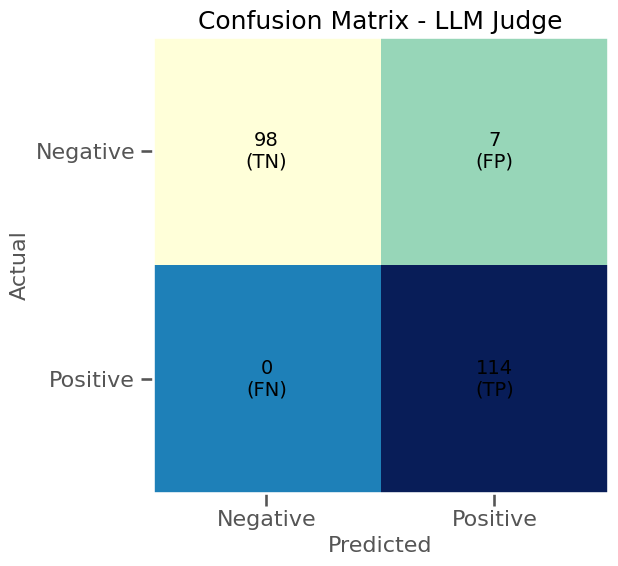

In [12]:
def compare_llm_model(test_data, model_predictions, model_name="LLM Model"):
    """
    Evaluate predictions from a single model against the ground truth and plot its confusion matrix.
    
    Parameters:
      - test_data (pandas.DataFrame): Test data with a column 'is_grounded' (0/1).
      - model_predictions (list): List of dictionaries with key 'score' in the 'result' sub-dictionary.
      - model_name (str): Name for the model.
      
    Returns:
      dict: A dictionary containing metrics for the model.
    """
    # Build the all_scores dictionary for the model.
    all_scores = {"llm_scores": [], "ground_truth": []}
    for i in range(len(test_data)):
        # Assumes each prediction is a dict with a 'result' sub-dictionary containing a 'score'
        all_scores["llm_scores"].append(model_predictions[i]["result"]["score"])
        all_scores["ground_truth"].append(test_data.iloc[i]["is_grounded"])
    
    # Validate and extract predictions and ground truth.
    predictions, ground_truth = validate_data(all_scores)
    ground_truth = ground_truth.astype(int)  # Ensure ground truth is int (0/1)
    
    # Compute metrics.
    metrics = compute_metrics(ground_truth, predictions)
    
    # Log the metrics.
    print_metrics(metrics, model_name)
    
    # Compute the confusion matrix.
    conf_matrix = confusion_matrix(ground_truth, predictions)
    
    # Plot the confusion matrix.
    plot_confusion_matrix(conf_matrix, model_name)
    
    return metrics

metrics = compare_llm_model(test_data, judge_predictions, model_name="LLM Judge")

### **Error Analysis**

**compute mistaches**

In [13]:
import json
import pandas as pd

def parse_result(result):
    """
    Helper function to parse the result field.
    If result is a JSON string, this attempts to parse it.
    If it's already a dict, it returns it as-is.
    """
    if isinstance(result, str):
        try:
            return json.loads(result)
        except Exception:
            return {}
    elif isinstance(result, dict):
        return result
    return {}

def process_predictions(predictions_list, test_data):
    """
    Converts a predictions list into a merged DataFrame with ground truth information.
    Assumes predictions_list is a list of dictionaries with a unique 'chunk_id' per test sample.
    """
    # Convert the list of predictions into a DataFrame.
    df_pred = pd.DataFrame(predictions_list)
    
    # Parse the 'result' field so we can extract the label.
    df_pred['parsed_result'] = df_pred['result'].apply(parse_result)
    
    # Create a boolean column from the parsed result.
    df_pred['predicted_label_bool'] = df_pred['parsed_result'].apply(
        lambda x: True if x.get('score') == 1 else False if x.get('score') == 0 else None
    )
    
    # Merge with the test_data DataFrame on 'chunk_id'
    merged_df = df_pred.merge(test_data[['chunk_id', 'is_grounded', 'difficulty', 'domain', 'synthetic_embedding']], 
                              on='chunk_id', how='left')
    return merged_df

def get_mismatch_df(merged_df, pred_col='predicted_label_bool', truth_col='is_grounded'):
    """
    Returns a DataFrame containing only the rows where the prediction does not match the ground truth.
    """
    # You might want to treat None as a mismatch as well.
    mismatch_df = merged_df[merged_df[pred_col] != merged_df[truth_col]]
    return mismatch_df

def compute_mismatches_single(model_predictions, test_data):
    """
    Processes predictions from a single model and returns a DataFrame containing only the mismatches
    compared to the test data.
    
    Parameters:
        model_predictions (list): List of dictionaries with a key 'result' containing a 'score'.
        test_data (pandas.DataFrame): Test data with a column 'is_grounded' and 'chunk_id'.
        
    Returns:
        pandas.DataFrame: DataFrame containing rows where the predicted label does not match the ground truth.
    """
    # Process the predictions.
    merged_df = process_predictions(model_predictions, test_data)
    # Get only the mismatches.
    mismatches = get_mismatch_df(merged_df)
    return mismatches

mismatches = compute_mismatches_single(judge_predictions, test_data)


In [14]:
mismatches

,chunk_id,result,parsed_result,predicted_label_bool,is_grounded,difficulty,domain,synthetic_embedding
41,252167c94bb6_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,"{'score': 1, 'explanation': 'The chunk provide...","{'score': 1, 'explanation': 'The chunk provide...",True,False,Beginner,Usage instructions,"[-0.02750384621322155, -0.005629627499729395, ..."
121,252167c94bb6_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,"{'score': 1, 'explanation': 'The chunk provide...","{'score': 1, 'explanation': 'The chunk provide...",True,False,Advanced,Product Description,"[-0.020829830318689346, 0.008331932127475739, ..."
131,c34dafd3cd3a_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,"{'score': 1, 'explanation': 'The chunk provide...","{'score': 1, 'explanation': 'The chunk provide...",True,False,Beginner,Product Description,"[0.021803105250000954, -0.04258846864104271, -..."
135,c34dafd3cd3a_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,"{'score': 1, 'explanation': 'The chunk provide...","{'score': 1, 'explanation': 'The chunk provide...",True,False,Advanced,Usage instructions,"[-0.03847866505384445, -0.05116141960024834, -..."
153,c34dafd3cd3a_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,"{'score': 1, 'explanation': 'The chunk provide...","{'score': 1, 'explanation': 'The chunk provide...",True,False,Advanced,Customer reviews,"[-0.0023085733409971, -0.0076001547276973724, ..."
162,c34dafd3cd3a_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,"{'score': 1, 'explanation': 'The chunk provide...","{'score': 1, 'explanation': 'The chunk provide...",True,False,Expert,Technical specifications,"[-0.02190079540014267, -0.005233596079051495, ..."
216,c34dafd3cd3a_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,"{'score': 1, 'explanation': 'The chunk contain...","{'score': 1, 'explanation': 'The chunk contain...",True,False,Intermediate,Customer reviews,"[-0.04103519022464752, -0.024521028622984886, ..."


In [17]:
# for index, row in mismatches.iterrows():
#     print()
#     print(f"question: {test_data[test_data['chunk_id'] == row['chunk_id']]['synthetic_question'].values[0]}")
#     print(f"context: {test_data[test_data['chunk_id'] == row['chunk_id']]['chunk_data'].values[0]}")
#     print(f"response: {test_data[test_data['chunk_id'] == row['chunk_id']]['synthetic_response'].values[0]}")
#     print(f"explanation: {row['result']['explanation']}")
#     print(f"score: {row['result']['score']}")
#     print(f"is_grounded: {row['is_grounded']}")
#     # print(row['is_grounded'])
#     # print(row['domain'])
#     # print(row['difficulty'])
    
#     print("-----")


**plotting mismatches**

In [18]:
def cluster_analysis_pca(df, metadata_col="difficulty", title="PCA Clustering"):
    """
    Runs PCA on a DataFrame containing a column 'synthetic_embedding' and a metadata column (specified by metadata_col).
    If only one sample exists in the DataFrame, a dummy sample is added along with a duplicate of its metadata.
    
    Parameters:
        df (pd.DataFrame): DataFrame (e.g., mismatches) containing columns 'synthetic_embedding' and metadata_col.
        metadata_col (str): Name of the metadata column to be used for coloring.
        title (str): Title for the plot.
    """
    # Create the figure and axis.
    fig, ax = plt.subplots(figsize=(8, 6))
    
    DUMMY_DATA = False
    synthetic_embeddings = []

    # Convert string representations of embeddings into numpy arrays.
    for j in range(len(df)):
        embedding_str = df['synthetic_embedding'].iloc[j]
        try:
            # Parse the string to a list and then convert to a numpy array.
            embedding_list = ast.literal_eval(embedding_str)
            embedding_array = np.array(embedding_list, dtype=np.float32)
            synthetic_embeddings.append(embedding_array)
        except Exception as e:
            print(f"Error parsing embedding at index {j}: {embedding_str}. Exception: {e}")
    
    # If no samples, display a message on the plot.
    if len(synthetic_embeddings) == 0:
        print("No samples available.")
        ax.set_title(f"{title} (No Data)")
        ax.text(0.5, 0.5, "No data available",
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes)
        plt.show()
        return
    
    # If only one sample is present, add a dummy sample.
    if len(synthetic_embeddings) == 1:
        print("Only one sample available, adding a dummy sample for PCA.")
        dummy_embedding = synthetic_embeddings[0]
        synthetic_embeddings.append(dummy_embedding)
        DUMMY_DATA = True
    
    # Stack the embeddings into a 2D array.
    synthetic_embeddings_array = np.vstack(synthetic_embeddings)
    
    # Run PCA to reduce the embeddings to 2 dimensions.
    pca = PCA(n_components=2, random_state=23)
    pca_results = pca.fit_transform(synthetic_embeddings_array)
    
    # Create a DataFrame with PCA results.
    df_pca = pd.DataFrame({
        'pc1': pca_results[:, 0],
        'pc2': pca_results[:, 1]
    })
    
    # Handle metadata: duplicate if a dummy sample was added.
    if DUMMY_DATA:
        df_meta = pd.DataFrame([df.iloc[0]] * 2).reset_index(drop=True)
    else:
        df_meta = df.reset_index(drop=True)
    
    # Combine PCA results with the metadata.
    df_combined = pd.concat([df_pca, df_meta], axis=1)
    
    # Plot the PCA results.
    sns.scatterplot(data=df_combined, x='pc1', y='pc2', hue=metadata_col, ax=ax)
    ax.set_title(f"{title} by '{metadata_col}'")
    
    plt.tight_layout()
    plt.show()


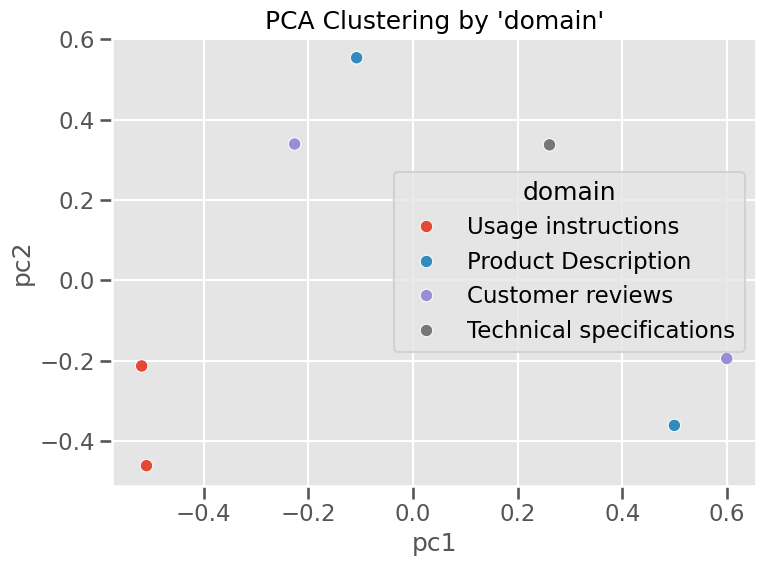

In [19]:
cluster_analysis_pca(mismatches, metadata_col="domain")

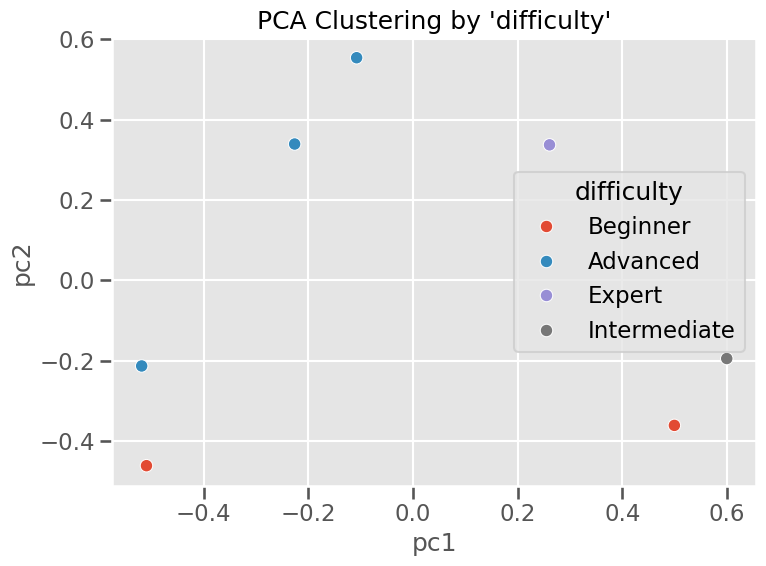

In [20]:
cluster_analysis_pca(mismatches, metadata_col="difficulty")